In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from src import train, generate, eval
from src.train import make_inference_model
from src.pipeline_util import load_bnn
from src.modules.config import read_config
import src.modules.plots as plots
from src.modules.datageneration import load_data, data_functions
import dill
import pickle
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import pyro
import pyro.poutine as poutine
import json

/Home/siv31/tak011/.conda/envs/master/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BASE_DIR = "../tests/sanity_check"
PROFILE = "tyxe-test-mcmc"

#BASE_DIR = "../tests/dataset-tests/sineasy10-10k-s05/"
#PROFILE = "sineasy10-3x128-s05"

In [4]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

config["EPOCHS"] = "300"
config["DEVICE"] = "cuda:0"
config["RERUNS"] = "1"
config["HIDDEN_FEATURES"] = "[32]"
config["LIKELIHOOD_SCALE"] = "0.3"
config["GUIDE_SCALE"] = "0.1"

config["MCMC_NUM_SAMPLES"] = "20"
config["MCMC_NUM_WARMUP"] = "10"
config["MCMC_NUM_CHAINS"] = "1"


dataset_config["DATA_FUNC"] = "sinusoidal"
dataset_config["DATA_FUNC"] = "sinusoidal"
dataset_config["SIGMA"] = "0.3"

====== Generating profile sin-(10,20)-10k ======
Train: (-10, 10)
Y-space: -1.8470730182375492 - 1.757711729724389
In Domain: (-10, 10)
Y-space: -1.7689647359468994 - 1.6668478296553313
Out Domain: (-20, 20)
Y-space: -1.583897416334067 - 1.8988115688755396


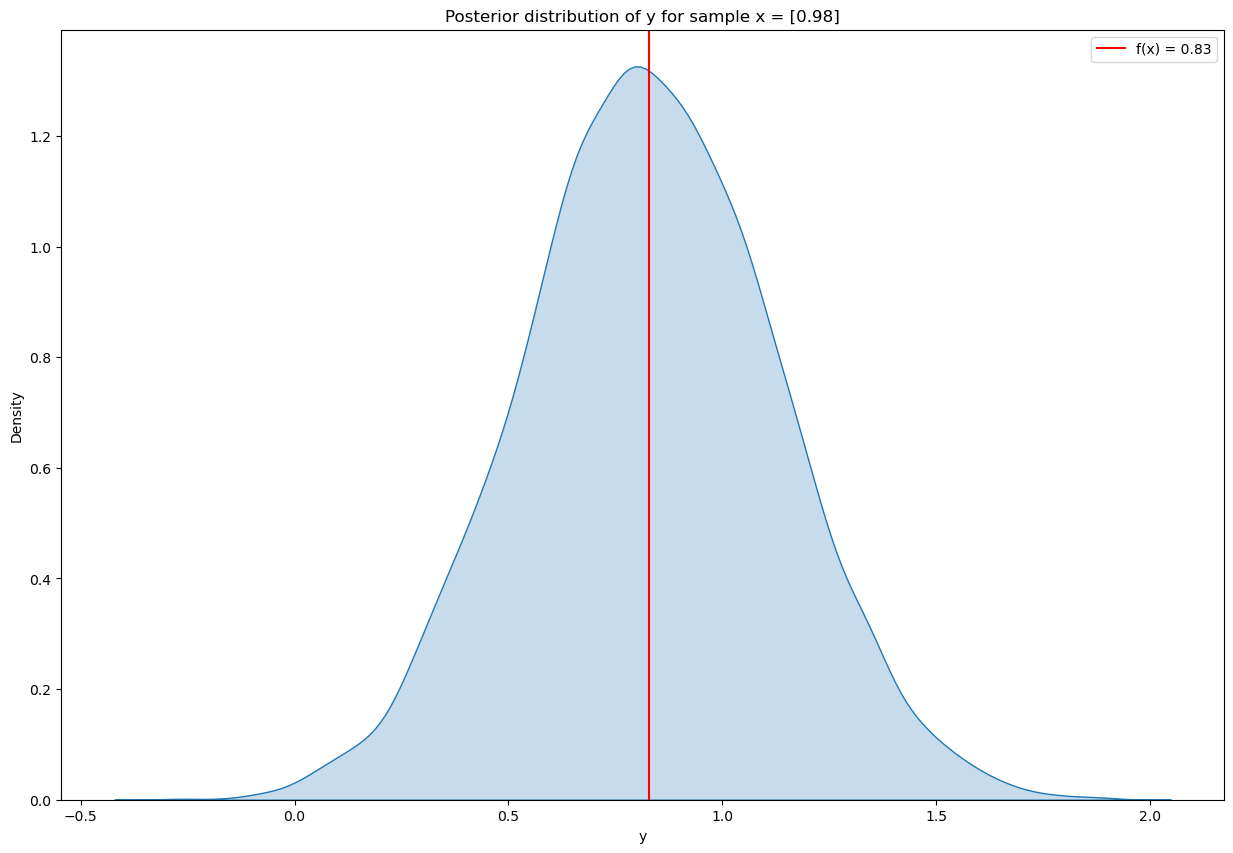

In [5]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [6]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test = torch.vstack((x_test_in_domain, x_test_out_domain))
y_test = torch.vstack((y_test_in_domain, y_test_out_domain))
print(x_test.shape, y_test.shape)

torch.Size([2000, 1]) torch.Size([2000, 1])


In [7]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([1000, 1]) torch.Size([1000, 1])
torch.Size([2000, 1]) torch.Size([2000, 1])


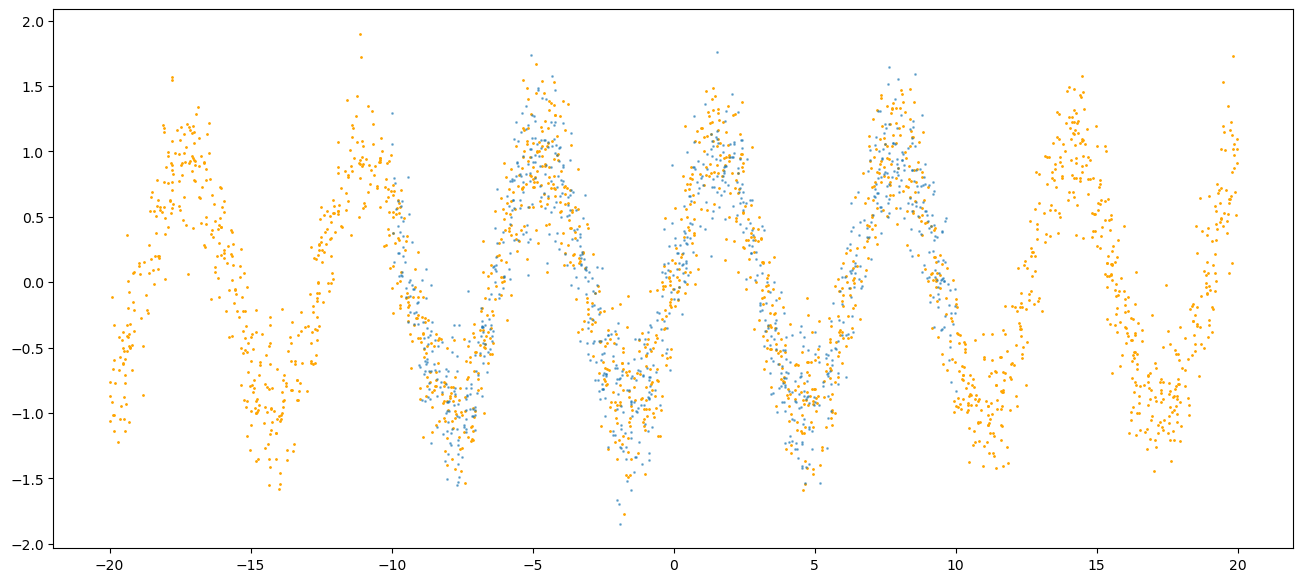

In [8]:
if dataset_config["X_DIM"] == "1":
    fig, ax = plt.subplots(figsize=(16, 7))
    plt.scatter(x_test.squeeze(), y_test, color="orange", s=1)
    plt.scatter(x_train.squeeze(), y_train, s=1, alpha=0.5)


In [9]:
if True:
    if not os.path.exists(f"{BASE_DIR}/models"):
                os.mkdir(f"{BASE_DIR}/models")
    if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")
    train.train(config, dataset_config, f"{BASE_DIR}", reruns=config.getint("RERUNS"))

Cuda Devices: [<torch.cuda.device object at 0x7f059cefbe20>, <torch.cuda.device object at 0x7f059cefb1f0>, <torch.cuda.device object at 0x7f059cefbf70>, <torch.cuda.device object at 0x7f059cefb340>, <torch.cuda.device object at 0x7f059cefbee0>, <torch.cuda.device object at 0x7f059cefb2b0>, <torch.cuda.device object at 0x7f059cefb250>, <torch.cuda.device object at 0x7f059cefb1c0>]
torch.Size([128, 1]) torch.Size([128, 1])
Settings:
DEVICE: cuda:0 INFERENCE_TYPE: mcmc OBS_MODEL: homoskedastic PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 0.3 GUIDE_SCALE: 0.1 TRAIN_SIZE: 1000
Using device: cuda:0
===== Training profile tyxe-test-mcmc - 1 =====


Warmup:   0%|                                                                                                                                                                                                               | 0/30 [00:00, ?it/s]/Home/siv31/tak011/.conda/envs/master/lib/python3.9/site-packages/pyro/poutine/subsample_messenger.py:63: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Warmup:  17%|███████▌                                     | 5/30 [00:04,  1.65it/s, step size=2.48e-04, acc. prob=0.600]                                                                                                                         

None
{'net.0.weight': tensor([[-0.1486],
        [ 1.4257],
        [ 1.7002],
        [-1.2314],
        [-1.1091],
        [ 0.2277],
        [ 1.6069],
        [ 0.1268],
        [-1.2624],
        [ 0.8607],
        [-0.7491],
        [ 0.4276],
        [ 0.1872],
        [-0.4638],
        [-1.4799],
        [ 0.6793],
        [-1.0989],
        [-1.6861],
        [ 0.7168],
        [-1.8478],
        [ 1.3911],
        [ 1.1122],
        [ 1.4252],
        [-0.6299],
        [-1.6537],
        [-0.3791],
        [ 1.6359],
        [-1.9904],
        [ 0.3913],
        [ 0.1898],
        [ 1.6001],
        [-1.4512]], device='cuda:0'), 'net.0.bias': tensor([ 0.6284, -1.6570, -0.5689, -1.9413, -0.4039, -0.7814, -1.2406, -1.2683,
         0.5224, -0.7067,  1.2773, -0.6758,  1.8314, -1.9396,  1.7338, -0.3204,
        -1.8070, -1.3745, -0.9197, -0.0092,  1.6622,  1.7010, -1.5034, -1.6494,
         1.4547,  1.9901, -1.1769, -1.6466, -1.1292,  1.2150,  1.7329, -1.5021],
       device='c

Warmup:  33%|██████████████▋                             | 10/30 [00:04,  3.95it/s, step size=5.09e-04, acc. prob=0.767]

None
None
None
{'net.0.weight': tensor([[-0.0654],
        [ 1.3776],
        [ 1.6971],
        [-1.2067],
        [-1.0867],
        [ 0.3614],
        [ 1.6363],
        [ 0.1011],
        [-1.2378],
        [ 0.8192],
        [-0.8999],
        [ 0.5527],
        [ 0.1837],
        [-0.3352],
        [-1.4052],
        [ 0.7217],
        [-1.2437],
        [-1.6708],
        [ 0.7965],
        [-1.8460],
        [ 1.4135],
        [ 1.2046],
        [ 1.4700],
        [-0.7369],
        [-1.6238],
        [-0.5880],
        [ 1.6044],
        [-2.0018],
        [ 0.2616],
        [ 0.0169],
        [ 1.5393],
        [-1.4103]], device='cuda:0'), 'net.0.bias': tensor([ 0.6486, -1.5875, -0.4109, -1.9323, -0.4245, -0.7636, -1.3069, -1.2795,
         0.3825, -0.5362,  1.2971, -0.7478,  1.8234, -1.9516,  1.6816, -0.5264,
        -1.8694, -1.3454, -0.9909, -0.0052,  1.6908,  1.7717, -1.5802, -1.6507,
         1.4052,  1.9660, -1.0466, -1.4432, -1.1404,  1.2155,  1.5408, -1.3886],
      

Sample:  47%|████████████████████▌                       | 14/30 [00:04,  5.11it/s, step size=5.09e-04, acc. prob=0.730]

None
None
None
None
None
{'net.0.weight': tensor([[ 0.0256],
        [ 1.3701],
        [ 1.5543],
        [-1.1813],
        [-1.1155],
        [ 0.2459],
        [ 1.6258],
        [ 0.0556],
        [-1.1339],
        [ 0.5799],
        [-0.7803],
        [ 0.7219],
        [ 0.1652],
        [-0.6073],
        [-0.8337],
        [ 0.9214],
        [-1.4574],
        [-1.7123],
        [ 0.8653],
        [-1.6169],
        [ 1.4177],
        [ 1.5992],
        [ 1.4578],
        [-0.9515],
        [-1.5975],
        [-1.1528],
        [ 1.3832],
        [-2.0418],
        [ 0.4673],
        [-0.1027],
        [ 1.3275],
        [-1.3629]], device='cuda:0'), 'net.0.bias': tensor([ 0.4927, -1.5470, -0.3327, -1.9074, -0.4051, -0.6644, -1.2171, -1.3984,
         0.4427, -0.4591,  1.4299, -0.5570,  1.8702, -2.4367,  1.9619, -0.2134,
        -1.8065, -1.3034, -1.1102, -0.1076,  1.6889,  1.6186, -1.5956, -1.5038,
         1.3986,  1.5850, -1.0938, -1.0294, -1.9442,  1.2468,  1.5742, -1.336

Sample:  57%|████████████████████████▉                   | 17/30 [00:06,  2.67it/s, step size=5.09e-04, acc. prob=0.740]

None
None


Sample:  63%|███████████████████████████▊                | 19/30 [00:10,  1.46it/s, step size=5.09e-04, acc. prob=0.665]

None


Sample:  67%|█████████████████████████████▎              | 20/30 [00:12,  1.20it/s, step size=5.09e-04, acc. prob=0.675]

None


Sample:  70%|██████████████████████████████▊             | 21/30 [00:13,  1.01it/s, step size=5.09e-04, acc. prob=0.700]

None
{'net.0.weight': tensor([[ 1.0790],
        [ 1.4997],
        [ 0.9992],
        [-0.9127],
        [-0.9308],
        [ 0.1849],
        [ 1.2457],
        [ 0.5136],
        [-1.1193],
        [ 1.1053],
        [-0.9638],
        [ 1.4498],
        [ 0.4436],
        [-0.5810],
        [-0.1735],
        [ 0.8961],
        [-1.0676],
        [-1.5725],
        [ 0.7122],
        [-1.1058],
        [ 1.6329],
        [ 1.8002],
        [ 2.0458],
        [-0.8109],
        [-1.3147],
        [-1.7479],
        [ 1.3068],
        [-1.7959],
        [ 0.4809],
        [-0.6105],
        [ 1.7096],
        [-1.3693]], device='cuda:0'), 'net.0.bias': tensor([-4.5637e-01, -1.6697e+00, -2.8737e-01, -9.8095e-01, -4.3968e-01,
         4.0864e-04, -7.8194e-01, -1.5818e+00,  2.0438e-01,  5.3212e-01,
         1.9967e+00, -1.1261e+00,  3.4048e+00, -2.7099e+00,  2.2493e+00,
        -3.2612e-01, -1.8575e+00, -7.4756e-01, -1.8754e+00,  6.2576e-01,
         1.7133e+00,  9.2043e-01, -1.4824e+00

Sample:  73%|████████████████████████████████▎           | 22/30 [00:15,  1.14s/it, step size=5.09e-04, acc. prob=0.687]

None


Sample:  77%|█████████████████████████████████▋          | 23/30 [00:17,  1.28s/it, step size=5.09e-04, acc. prob=0.663]

None


Sample:  80%|███████████████████████████████████▏        | 24/30 [00:19,  1.39s/it, step size=5.09e-04, acc. prob=0.653]

None


Sample:  83%|████████████████████████████████████▋       | 25/30 [00:21,  1.49s/it, step size=5.09e-04, acc. prob=0.671]

None


Sample:  87%|██████████████████████████████████████▏     | 26/30 [00:22,  1.56s/it, step size=5.09e-04, acc. prob=0.689]

None
{'net.0.weight': tensor([[ 0.8145],
        [ 1.0260],
        [ 1.6045],
        [ 0.2250],
        [-1.5158],
        [ 0.4990],
        [ 0.7632],
        [ 0.5609],
        [-0.6734],
        [ 0.2640],
        [-0.9852],
        [ 0.7028],
        [ 0.4736],
        [-0.6076],
        [-0.6836],
        [ 0.1553],
        [-0.9385],
        [-1.0652],
        [ 0.5681],
        [-0.5902],
        [ 0.8121],
        [-0.0859],
        [ 1.4843],
        [-0.1647],
        [-1.4720],
        [-1.3256],
        [ 0.7387],
        [-1.1376],
        [ 0.6451],
        [-0.6109],
        [ 1.3833],
        [-1.2383]], device='cuda:0'), 'net.0.bias': tensor([-0.1763, -2.5351, -0.4777, -0.1046, -1.1216, -0.3393, -0.9514, -1.9812,
         0.6447,  0.2479,  2.0444, -0.5526,  3.6367, -2.8816,  1.8986, -0.4113,
        -1.5591, -0.6759, -0.8456,  0.6911,  0.8655,  0.1775, -1.2137, -0.1151,
         1.3697,  0.5439, -0.7267, -1.0459, -3.1184,  4.7461,  0.3195, -1.9405],
       device='c

Sample:  90%|███████████████████████████████████████▌    | 27/30 [00:24,  1.62s/it, step size=5.09e-04, acc. prob=0.683]

None


Sample:  93%|█████████████████████████████████████████   | 28/30 [00:26,  1.66s/it, step size=5.09e-04, acc. prob=0.696]

None


Sample:  97%|██████████████████████████████████████████▌ | 29/30 [00:28,  1.69s/it, step size=5.09e-04, acc. prob=0.694]

None


Sample: 100%|████████████████████████████████████████████| 30/30 [00:29,  1.00it/s, step size=5.09e-04, acc. prob=0.707]


None
Training finished in 0:00:30.271466 seconds
Saved MCMC samples to ../tests/sanity_check/models/tyxe-test-mcmc/checkpoint_1.pt
File Size is 0.008402824401855469 MB
Settings:
DEVICE: cpu INFERENCE_TYPE: mcmc OBS_MODEL: homoskedastic PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 0.3 GUIDE_SCALE: 0.1 TRAIN_SIZE: 1000
init mcmc


Warmup:   0%|                                                                                                                                                                                                                | 0/2 [00:00, ?it/s]/Home/siv31/tak011/.conda/envs/master/lib/python3.9/site-packages/pyro/poutine/subsample_messenger.py:63: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████████████████████████████████████████| 2/2 [00:00, 14.76it/s, step size=2.50e-01, acc. prob=0.000]                                                                                                                         


Loaded MCMC samples from ../tests/sanity_check/models/tyxe-test-mcmc/checkpoint_1.pt
{'net.0.bias': {'n_eff': tensor([ 4.4513,  2.7854, 22.7653,  2.4502,  3.0172,  5.5983,  7.0946,  3.1744,
         8.5919,  5.5137,  5.2176,  4.8835,  2.7886,  2.8503,  6.5999, 11.5241,
         3.6551,  2.5375,  4.8233,  3.2926,  4.8291,  2.7179,  4.2803,  2.9020,
         9.3268,  2.7321,  5.6048,  5.4947,  3.5187,  3.5944,  2.7054,  4.8533])}, 'net.0.weight': {'n_eff': tensor([[4.3848],
        [5.4548],
        [6.4917],
        [3.4583],
        [3.1451],
        [9.6944],
        [2.7341],
        [2.5211],
        [5.7990],
        [7.8824],
        [6.6629],
        [4.1592],
        [2.6535],
        [9.7623],
        [4.3206],
        [2.7124],
        [3.9929],
        [3.0505],
        [5.5906],
        [2.9775],
        [2.9953],
        [2.9076],
        [5.4358],
        [3.5375],
        [5.2838],
        [4.3803],
        [2.7768],
        [3.0298],
        [4.5257],
        [3.4047],
 

In [10]:
with open(f"{BASE_DIR}/results/{NAME}/mcmc_diagnostics_1.pkl", "rb") as f:
    diag = pickle.load(f)

In [11]:
diag

{'net.0.bias': {'n_eff': tensor([ 4.4513,  2.7854, 22.7653,  2.4502,  3.0172,  5.5983,  7.0946,  3.1744,
           8.5919,  5.5137,  5.2176,  4.8835,  2.7886,  2.8503,  6.5999, 11.5241,
           3.6551,  2.5375,  4.8233,  3.2926,  4.8291,  2.7179,  4.2803,  2.9020,
           9.3268,  2.7321,  5.6048,  5.4947,  3.5187,  3.5944,  2.7054,  4.8533])},
 'net.0.weight': {'n_eff': tensor([[4.3848],
          [5.4548],
          [6.4917],
          [3.4583],
          [3.1451],
          [9.6944],
          [2.7341],
          [2.5211],
          [5.7990],
          [7.8824],
          [6.6629],
          [4.1592],
          [2.6535],
          [9.7623],
          [4.3206],
          [2.7124],
          [3.9929],
          [3.0505],
          [5.5906],
          [2.9775],
          [2.9953],
          [2.9076],
          [5.4358],
          [3.5375],
          [5.2838],
          [4.3803],
          [2.7768],
          [3.0298],
          [4.5257],
          [3.4047],
          [7.9971],
 

In [12]:
bnn = make_inference_model(config, dataset_config)
bnn = load_bnn(bnn, config, f"{BASE_DIR}/models/{NAME}/checkpoint_1.pt")

Settings:
DEVICE: cuda:0 INFERENCE_TYPE: mcmc OBS_MODEL: homoskedastic PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 0.3 GUIDE_SCALE: 0.1 TRAIN_SIZE: 1000
init mcmc


Warmup:   0%|                                                                                                                                                                                                                | 0/2 [00:00, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_addmm)
    Trace Shapes:       
     Param Sites:       
    Sample Sites:       
net.0.weight dist | 32 1
            value | 32 1
  net.0.bias dist | 32  
            value | 32  

In [ ]:
preds2 = bnn.predict(x_test, num_predictions=100, aggregate=False)

In [ ]:
weight_samps = bnn.get_weight_distributions(num_samples=4)
weight_samps.keys()

In [ ]:
checkpoint = torch.load(f"{BASE_DIR}/models/{NAME}/checkpoint_1_10.pt", map_location="cpu", pickle_module=dill)

In [ ]:
checkpoint["samples"]["net.0.weight"]

In [ ]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)
p = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=False)

means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

In [ ]:
print(means[0])
print(p[:, 0].mean())

In [ ]:
if dataset_config["X_DIM"] == "1":
    fig, ax = plt.subplots(figsize=(16, 7))
    plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
    plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
    plt.plot(x_test[test_sort], means, color="blue")
    #plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
    for c in range(1, 4):
        plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

In [ ]:
if dataset_config["X_DIM"] == "1":
    sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=15, aggregate=False)
    fig, ax = plt.subplots(figsize=(16, 7))
    plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
    plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
    for yhat in sampled_predictions:
        plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)

In [ ]:

if not os.path.exists(f"{BASE_DIR}/results"):
            os.mkdir(f"{BASE_DIR}/results")           
eval.eval(config, dataset_config, f"{BASE_DIR}", bnn=None)

In [ ]:
profiles= [PROFILE]

colors = ["green"]

names = [configs[p]["NAME"] for p in profiles]

In [ ]:
from IPython.display import display, HTML

train_stats = {}
for p in profiles:
    name = configs[p]["NAME"]
    with open(f"{BASE_DIR}/results/{name}/train_stats_1.json", "r") as f:
        train_stats[name] = json.load(f)

results = {}
for p in profiles:
    name = configs[p]["NAME"]
    with open(f"{BASE_DIR}/results/{name}/results_1.json", "r") as f:
        results[name] = json.load(f)

# Load posterior samples
posterior_samples = {}
for p in profiles:
    name = configs[p]["NAME"]
    # Load posterior samples
    train = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/train_samples_1.npy")
    test = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_samples_1.npy")
    test_in_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_in_domain_samples_1.npy")
    test_out_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_out_domain_samples_1.npy")

    posterior_samples[name] = {
        "train": train,
        "test": test,
        "test_in_domain": test_in_domain,
        "test_out_domain": test_out_domain
    }

In [ ]:
#Generate table for rmse
table = pd.DataFrame(columns=["Name", "Likelihood_std", "Train RMSE", "In domain RMSE", "Out domain RMSE"])
for p in profiles:
    name = configs[p]["NAME"]
    table = table.append({
        "Name": name,
        "Train RMSE": results[name]["train"]["error"]["rmse"],
        "In domain RMSE": results[name]["in_domain"]["error"]["rmse"],
        "Out domain RMSE": results[name]["out_domain"]["error"]["rmse"],
        "Likelihood_std": train_stats[name]["likelihood"]["mean"]
    }, ignore_index=True)

display(table)
print()

#Generate table for mae
table = pd.DataFrame(columns=["Name", "Likelihood_std", "Train MAE", "In domain MAE", "Out domain MAE"])
for p in profiles:
    name = configs[p]["NAME"]
    table = table.append({
        "Name": name,
        "Train MAE": results[name]["train"]["error"]["mae"],
        "In domain MAE": results[name]["in_domain"]["error"]["mae"],
        "Out domain MAE": results[name]["out_domain"]["error"]["mae"],
        "Likelihood_std": train_stats[name]["likelihood"]["mean"]
    }, ignore_index=True)

display(table)
print()

#Generate table for log likelihood
table = pd.DataFrame(columns=["Name", "Likelihood_std", "Train log likelihood", "In domain log likelihood", "Out domain log likelihood"])
for p in profiles:
    name = configs[p]["NAME"]
    table = table.append({
        "Name": name,
        "Train log likelihood": results[name]["train"]["error"]["loglikelihood"],
        "In domain log likelihood": results[name]["in_domain"]["error"]["loglikelihood"],
        "Out domain log likelihood": results[name]["out_domain"]["error"]["loglikelihood"],
        "Likelihood_std": train_stats[name]["likelihood"]["mean"]
    }, ignore_index=True)

display(table)

In [ ]:
if config["INFERENCE_TYPE"] != "nn":
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("Elbos")
    for i, p in enumerate(profiles):
        name = configs[p]["NAME"]
        elbos = np.log(train_stats[name]["elbos"])
        ax.plot(elbos, label=name)
    ax.legend()
    plt.show()
else:
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("MSE loss")
    for i, p in enumerate(profiles):
        name = configs[p]["NAME"]
        elbos = np.log(train_stats[name]["loss"])
        ax.plot(elbos, label=name)
    ax.legend()
    plt.show()


In [ ]:
if config["INFERENCE_TYPE"] != "nn":
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("RMSE")
    for i, p in enumerate(profiles):
        name = configs[p]["NAME"]
        te = train_stats[name]["train_rmse"]
        ax.plot(te, '--', label=f"{name}-train", color=colors[i])
        ve = train_stats[name]["val_rmse"]
        ax.plot(ve, label=f"{name}-val", color=colors[i])
        ax.set_yscale('symlog', base=10)
    ax.legend()
    plt.show()

In [ ]:
if config["INFERENCE_TYPE"] != "nn":
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("Log Likelihood")
    for i, p in enumerate(profiles):
        name = configs[p]["NAME"]
        tll = train_stats[name]["train_ll"]
        ax.plot(tll, '--', label=f"{name}-train", color=colors[i])
        vll = train_stats[name]["val_ll"]
        ax.plot(vll, label=f"{name}-val", color=colors[i])
        ax.set_yscale('symlog', basey=10)
    ax.legend()
    plt.show()

In [ ]:
name1 = configs[profiles[0]]["NAME"]
data_samples = {
    "train_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_x.npy"),
    "test_in_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_x.npy"),
    "test_out_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_x.npy"),
    #"test_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_x.npy"),
    "train_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_dist_samples.npy"),
    "test_in_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_dist_samples.npy"),
    "test_out_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_dist_samples.npy"),
    #"test_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_dist_samples.npy"),
}

In [ ]:
trace = poutine.trace(bnn.guide, param_only=True).get_trace(torch.ones(1, 1))
for name, value in trace.nodes.items():
    print(name, value["value"])